In [1]:
import pandas as pd
import ast
import networkx as nx
import matplotlib.pyplot as plt
import igraph as ig
import pickle
from collections import Counter
import csv
import itertools
from tqdm import tqdm

In [ ]:
# Load CSV file into a pandas DataFrame, the file has a header row with the column names and the separator is a comma, ignore 7th column
df = pd.read_csv("song_lyrics.csv")

# Print the first 5 rows of the dataframe
print(df.head(), len(df))

In [ ]:
# Drop lyrics, language_cld3, language_ft, language columns
df = df.drop(columns=["lyrics", "language_cld3", "language_ft", "language"])

# Drop rows with empty values in the features columns where "{}"" is equal to empty
df = df.loc[df["features"] != "{}"]

# Print the first 5 rows of the dataframe
print(df.head(), len(df))

# Save the dataframe to a new CSV file
df.to_csv("song_feats.csv", index=False)

In [ ]:
def process_row(row):
    # Convert string representation of list to list
    original_features = row["features"]
    features = original_features.strip("{}").split(",")
    features = {f.replace("\\", "").strip(' " ') for f in features}

    artist = row["artist"]

    # If there's only one feature and it's equal to the artist name, return None
    if len(features) == 1 and artist in features:
        return None

    # Otherwise, return the features
    return str(features)


# Apply the function to each row
df["features"] = df.apply(process_row, axis=1)

# Drop rows with None in the "features" column
df = df.dropna(subset=["features"])

# Drop views column
df = df.drop(columns=["views"])

print(df.head(), len(df))

# Save the dataframe to a new CSV file
df.to_csv("song_feats.csv", index=False)

In [ ]:
# Load CSV if df variable is not in locals
if "df" not in locals():
    df = pd.read_csv("song_feats.csv")

In [ ]:
artists = pd.DataFrame(df["artist"].unique(), columns=["artist_name"])
print(artists.head(), len(artists))

In [ ]:
genres = df.groupby("artist")["tag"].apply(list).reset_index()
genres["tag"] = genres["tag"].apply(
    lambda x: sorted(Counter(x).items(), key=lambda item: item[1], reverse=True)[0][0]
)
print(genres.head(), len(genres))

In [ ]:
collabs = df.groupby("artist")["features"].apply(list).reset_index()
collabs["features"] = collabs["features"].apply(
    lambda x: set().union(*[ast.literal_eval(i) for i in x])
)
print(collabs.head(), len(collabs))

In [ ]:
artists = pd.merge(
    artists, genres, left_on="artist_name", right_on="artist", how="left"
).drop(columns="artist")
artists = pd.merge(
    artists, collabs, left_on="artist_name", right_on="artist", how="left"
).drop(columns="artist")


print(artists.head(), len(artists))

In [ ]:
# Create nodes CSV
artists["id"] = range(1, len(artists) + 1)

# Save the dataframe to a new CSV file
artists.to_csv("artists.csv", index=False)

In [ ]:
# Load CSV if artists variable is not in locals
artists = pd.read_csv("artists.csv")

# Filter out artists with less than 10 collaborations
artists = artists.loc[artists["features"].apply(len) >= 10]

# Randomly sample 10000 artists
artists = artists.sample(10000, random_state=42)

# Save the dataframe to a new CSV file
artists.to_csv("artists_filtered.csv", index=False)

In [ ]:
artists.to_csv(
    "nodes.csv",
    columns=["id", "artist_name", "tag"],
    header=["Id", "Label", "Genre"],
    index=False,
)

In [ ]:
# Initialize an empty list to store edges
edges = []

# set from artists["artist_name"].values
artists_set = set(artists["artist_name"].values)

# Iterate over each row in the DataFrame
for index, row in tqdm(df.iterrows(), total=len(df)):
    # Get the artist name
    artist = row["artist"]

    # Get the features
    features = ast.literal_eval(row["features"])

    # If the artist is not in the set of artists, skip
    if artist not in artists_set:
        continue

    # Iterate over each feature
    for feature in features:
        # If the feature is not in the set of artists, skip
        if feature not in artists_set:
            continue

        # Append the artist and feature as a tuple to the edges list, use id from artists dataframe
        edges.append(
            (
                artists.loc[artists["artist_name"] == artist, "id"].values[0],
                artists.loc[artists["artist_name"] == feature, "id"].values[0],
            )
        )

# Create edges CSV
with open("edges.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Source", "Target"])  # write header
    writer.writerows(edges)

In [ ]:
# Filter out nodes that don't have any edges
nodes = pd.read_csv("nodes.csv")
edges = pd.read_csv("edges.csv")

# Get unique sources and targets
sources = set(edges["Source"].values)
targets = set(edges["Target"].values)

# Get the union of sources and targets
nodes_set = sources.union(targets)

# Filter out nodes that don't have any edges
nodes = nodes.loc[nodes["Id"].isin(nodes_set)]

# Save the dataframe to a new CSV file
nodes.to_csv("nodes_filtered.csv", index=False)

In [2]:
# Import edges from CSV to list
edges = pd.read_csv("edges.csv").values.tolist()

# Import nodes from CSV
nodes = pd.read_csv("nodes_filtered.csv")

[(121, 35, {'weight': 1}), (121, 307, {'weight': 2}), (35, 668, {'weight': 1}), (35, 42, {'weight': 2}), (35, 2553, {'weight': 1}), (35, 565, {'weight': 1}), (35, 4142, {'weight': 2}), (35, 167874, {'weight': 1}), (35, 120, {'weight': 2}), (35, 960, {'weight': 1}), (35, 259, {'weight': 1}), (35, 116028, {'weight': 1}), (35, 307, {'weight': 1}), (152, 310, {'weight': 3}), (310, 305, {'weight': 1}), (42, 2067, {'weight': 1}), (42, 129, {'weight': 9}), (42, 120, {'weight': 2}), (42, 307, {'weight': 1}), (42, 9639, {'weight': 2}), (42, 8687, {'weight': 3}), (42, 71, {'weight': 1}), (42, 17619, {'weight': 1}), (2067, 71, {'weight': 1}), (2067, 129, {'weight': 1}), (696, 13, {'weight': 1}), (696, 307, {'weight': 1}), (13, 2797, {'weight': 1}), (13, 307, {'weight': 5}), (13, 403, {'weight': 1}), (668, 802, {'weight': 1}), (802, 5102, {'weight': 6}), (802, 305, {'weight': 1}), (802, 24618, {'weight': 1}), (802, 123340, {'weight': 1}), (5102, 24618, {'weight': 14}), (860, 1069, {'weight': 1}), 

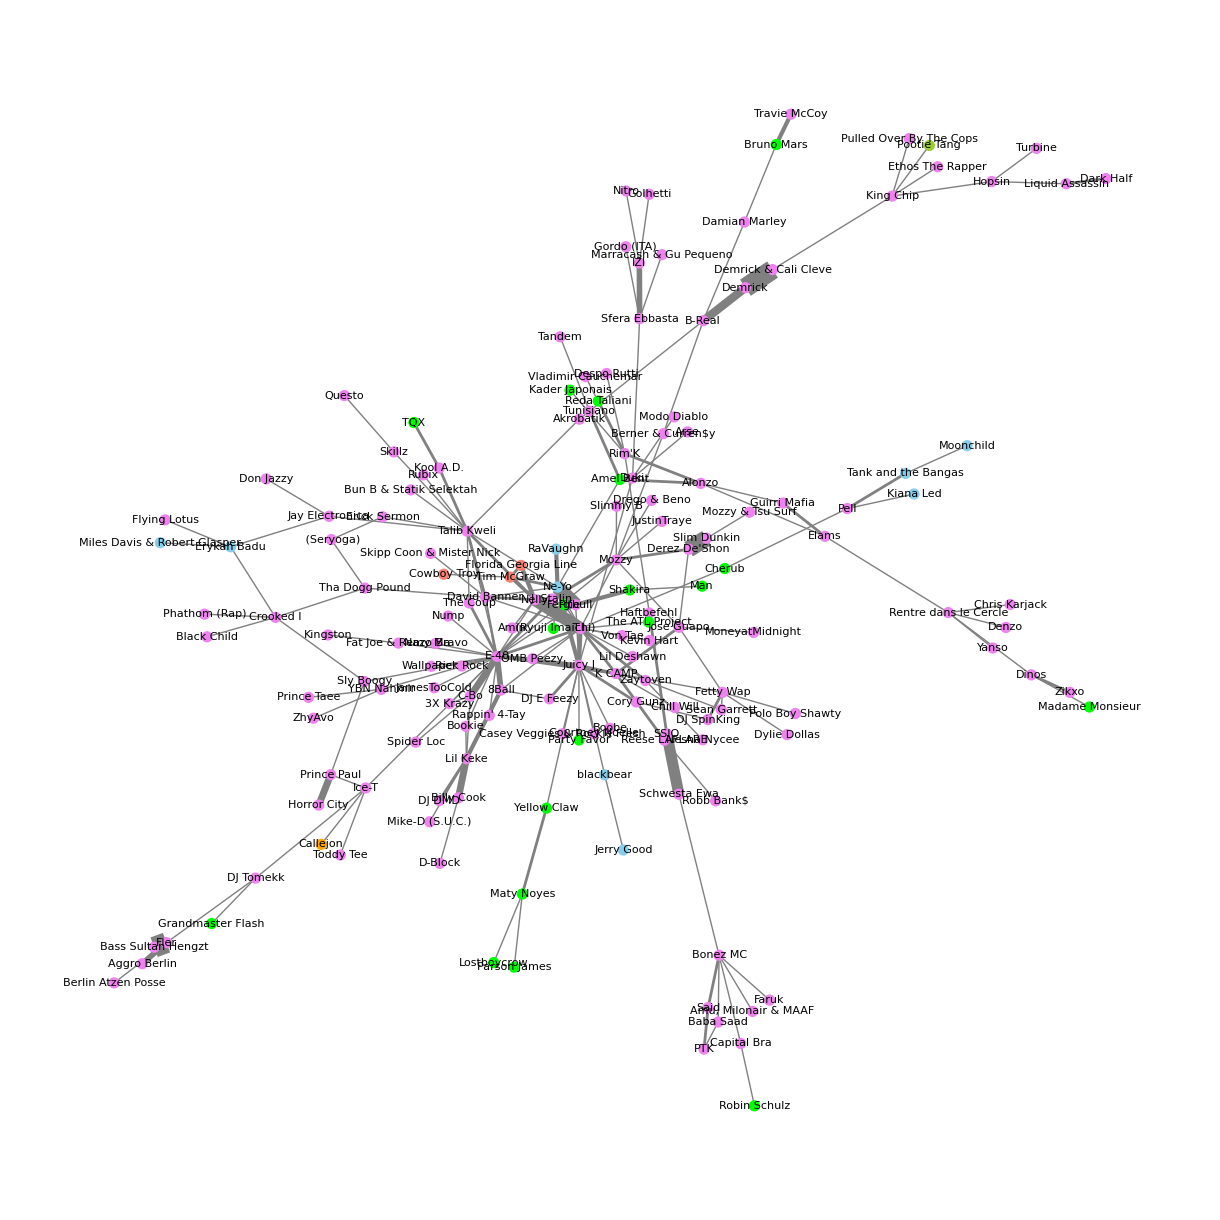

In [3]:
# Create undirected graph from edges, summing the weights from duplicates, incorporate information from nodes, avoid self-loops
G = nx.Graph()
for edge in edges:
    source, target = edge
    if source != target:
        if G.has_edge(source, target):
            G[source][target]["weight"] += 1
        else:
            G.add_edge(source, target, weight=1)

# Add node attributes
for index, row in nodes.iterrows():
    node = row["Id"]
    if node in G.nodes:
        G.nodes[node]["Label"] = row["Label"]
        G.nodes[node]["Genre"] = row["Genre"]

print(G.edges(data=True))


# Create a new graph with only the largest subgraph
subgraphs = list(nx.connected_components(G))
G = G.subgraph(subgraphs[0])

# Create a dictionary mapping node IDs to labels
labels = {node: data["Label"] for node, data in G.nodes(data=True)}

# Define a dictionary mapping genres to colors
genre_color = {
    "rap": "violet",
    "pop": "lime",
    "rb": "skyblue",
    "rock": "orange",
    "misc": "yellowgreen",
    "country": "salmon",
}

# Create a list of colors corresponding to the genres of the nodes
node_colors = [genre_color[data["Genre"]] for node, data in G.nodes(data=True)]

weights = [data["weight"] for source, target, data in G.edges(data=True)]

# Plot the graph
plt.figure(figsize=(12, 12))
nx.draw(
    G,
    labels=labels,
    with_labels=True,
    node_size=50,
    font_size=8,
    font_color="black",
    node_color=node_colors,
    edge_color="gray",
    width=weights,
)
plt.show()

[frozenset({6144, 53385, 35605}), frozenset({6144, 24072, 10695}), frozenset({129, 1542, 71, 10695, 54983, 718, 2067, 35605, 5596, 35, 42, 307, 2612, 565, 120, 121, 68861}), frozenset({18000, 4628, 41463}), frozenset({24618, 802, 5102}), frozenset({696, 307, 13}), frozenset({42, 8687, 9639})]
7


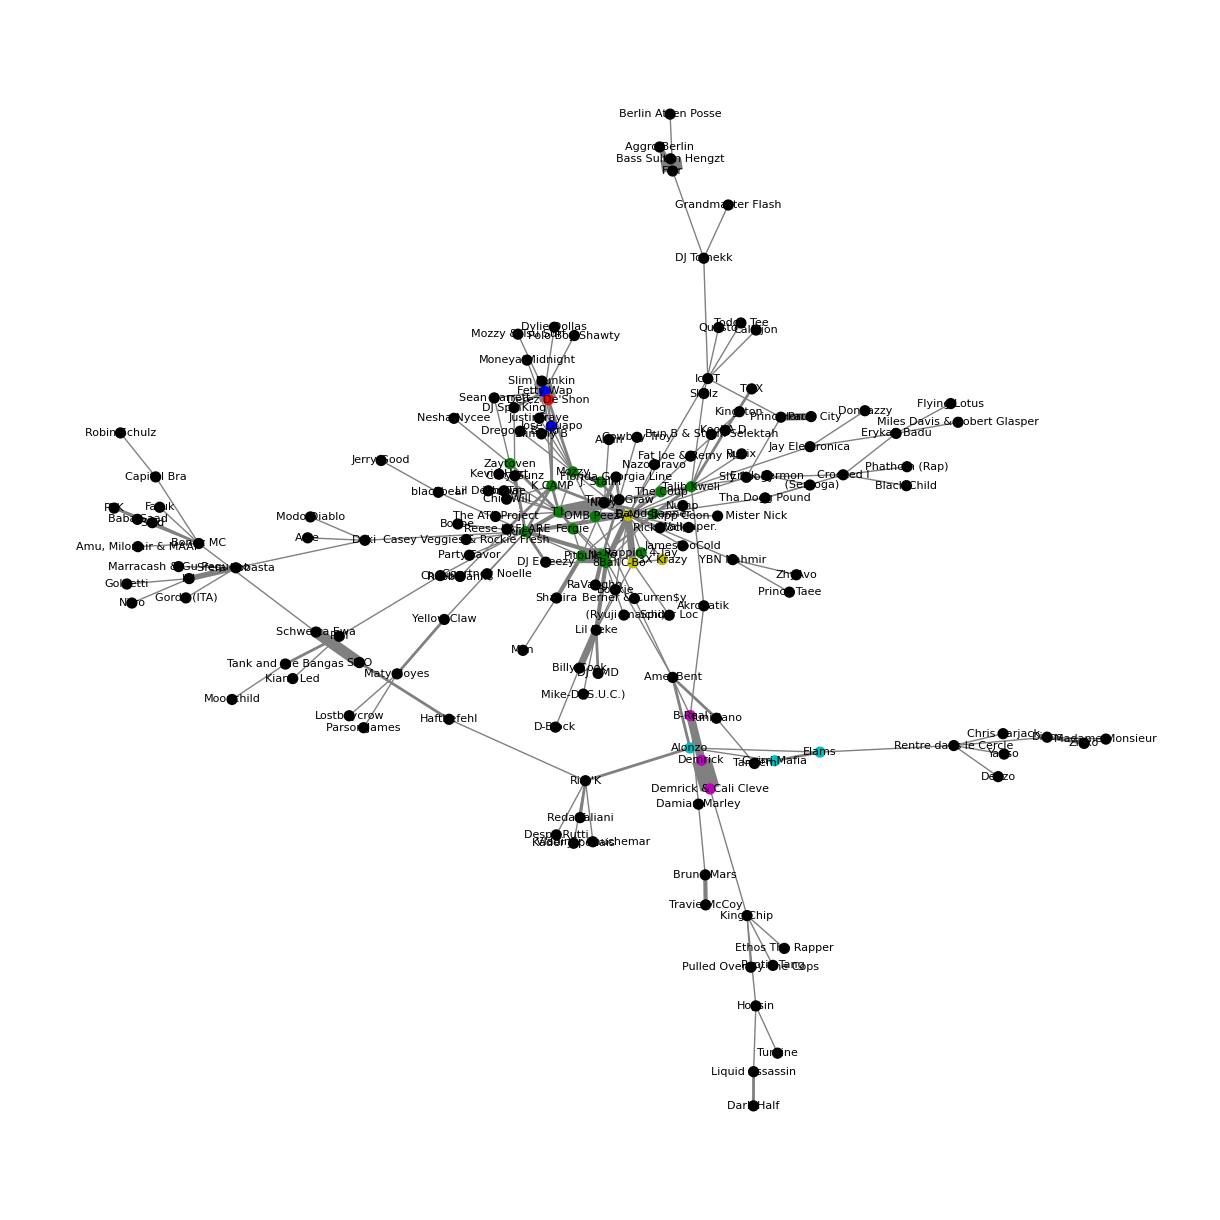

In [4]:
# Find cliques using CPM algorithm
cliques = list(
    nx.algorithms.community.k_clique_communities(G, 3, cliques=nx.find_cliques(G))
)
print(cliques)
print(len(cliques))

# Plot the graph with cliques as color, each clique has a different color
color_map = ["k"] * len(G.nodes())
colors = ["r", "b", "g", "c", "m", "y", "k"]
colors_comm = colors * (1 + len(cliques) // len(colors))

# Create a dictionary mapping node IDs to their index in the node list
node_indices = {node: i for i, node in enumerate(G.nodes)}

for i, clique in enumerate(cliques):
    for node in clique:
        color_map[node_indices[node]] = colors_comm[i]

plt.figure(figsize=(12, 12))
nx.draw(
    G,
    labels=labels,
    with_labels=True,
    node_size=50,
    font_size=8,
    font_color="black",
    node_color=color_map,
    edge_color="gray",
    width=weights,
)

[{9475, 1542, 71, 137067, 14669, 7501, 49583, 103149, 40497, 565, 8406, 3191, 3127, 16858, 14238}, {960, 129, 167874, 54983, 1035, 120402, 17619, 2067, 793, 72217, 665, 120, 668, 4515, 35, 9639, 42, 23658, 4142, 8687, 17711, 175534, 25016, 116028}, {305, 802, 310, 152, 24618, 5102}, {8465, 70645, 45366, 74919, 9867}, {4355, 227013, 121162, 150221, 4813, 18000, 4628, 232415, 64162, 90723, 73061, 45350, 15335, 3049, 6442, 68779, 3054, 41463}, {64705, 106307, 58947, 40771, 35529, 42094, 234223, 117527, 47741}, {1796, 45252, 33675, 13, 718, 1165, 127377, 403, 11924, 860, 151261, 33121, 9002, 70060, 2797, 1069, 160625, 307, 2612, 696, 121, 68861, 105406, 895}, {55616, 354, 130, 142249, 61069, 13075, 4187, 3647}, {6144, 7012, 10695, 24072, 65900, 78128, 18832, 4594, 12342, 54681}, {39297, 259, 39620, 332, 526, 5455, 2769, 32852, 1494, 2590, 45794, 1125, 47914, 1132, 1199, 816, 13169, 2553, 12988}, {9631, 53186, 56957, 43759}, {8509, 3460, 8925, 9158}, {8868, 18597, 23494, 139910, 23191, 1394

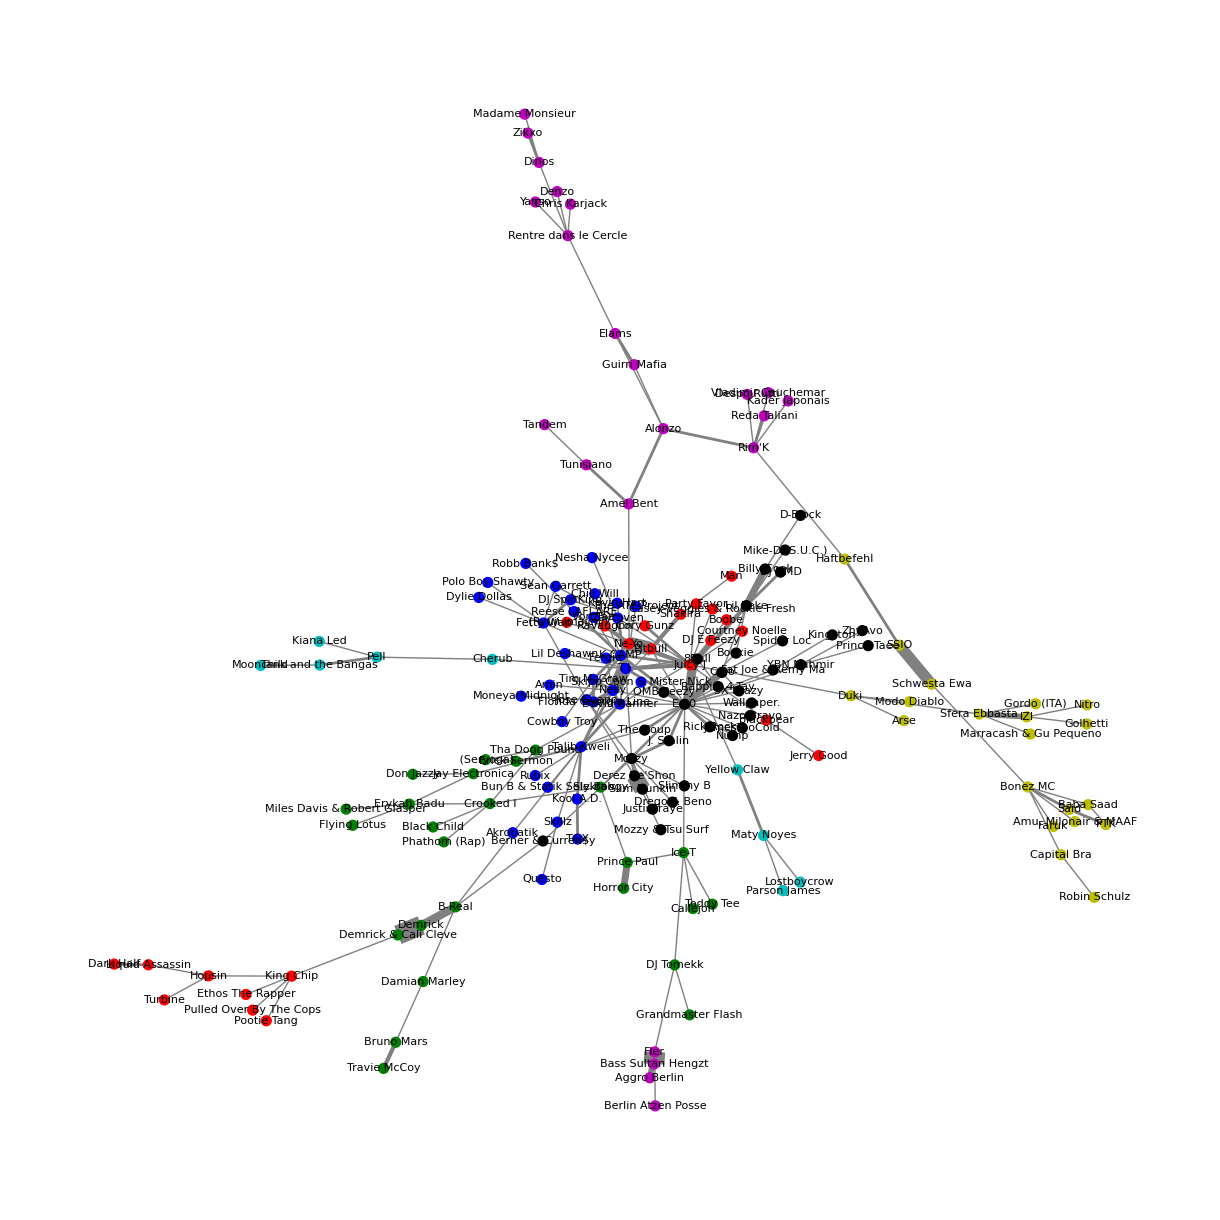

In [5]:
# Detect communities using Louvain method
communities = nx.algorithms.community.louvain_communities(G)
print(communities)
print(len(communities))

# Get modularity
modularity = nx.algorithms.community.quality.modularity(G, communities)
print(modularity)

# Plot the graph with communities as color, each community has a different color
color_map = ["k"] * len(G.nodes())
colors = ["r", "b", "g", "c", "m", "y", "k"]
colors_comm = colors * (1 + len(communities) // len(colors))

for i, community in enumerate(communities):
    for node in community:
        color_map[node_indices[node]] = colors_comm[i]

plt.figure(figsize=(12, 12))
nx.draw(
    G,
    labels=labels,
    with_labels=True,
    node_size=50,
    font_size=8,
    font_color="black",
    node_color=color_map,
    edge_color="gray",
    width=weights,
)
plt.show()